In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
paths = [
    "../../dane/8CPU_20RAM/21600s/2repl/",
    "../../dane/8CPU_20RAM/21600s/4repl/",
    "../../dane/8CPU_20RAM/21600s/5repl/",
    "../../dane/8CPU_20RAM/21600s/6repl/",
    "../../dane/8CPU_20RAM/21600s/A1_100-A2_100-A3_100/",
    "../../dane/8CPU_20RAM/21600s/A1_200-A3_100/",
    "../../dane/8CPU_20RAM/21600s/A2_200/",
#     "../dane/8CPU_20RAM/3600s/A2_200-A3_100/",
    # "../dane/8CPU_20RAM/3600s/A3_200/",
    # "../dane/8CPU_20RAM/3600s/req_250ms/",
    "../../dane/8CPU_20RAM/21600s/req_500ms/",
    # "../dane/8CPU_20RAM/3600s/req_1000ms/",
    "../../dane/8CPU_20RAM/21600s/req_2000ms/",
    # "../dane/8CPU_20RAM/3600s/trans_60s/",
    # "../dane/8CPU_20RAM/3600s/trans_120s/",
    "../../dane/8CPU_20RAM/21600s/trans_180s/",
    # "../dane/8CPU_20RAM/3600s/trans_240s/",
    "../../dane/8CPU_20RAM/21600s/trans_300s/"]

testPath =  "../../dane/8CPU_20RAM/21600s/A2_200-A3_100/"

In [3]:
def process_data(path):
    methods_df = pd.read_csv(path + "methods.csv").dropna()
    stock_df = pd.read_csv(path + "stock.csv").dropna()
    trading_df = pd.read_csv(path + "trading.csv").dropna()
    traffic_df = pd.read_csv(path + "traffic.csv").dropna()

    methods_df.columns = [f"{col}_methods" if col not in ['timestamp', 'replicaId'] else col for col in methods_df.columns]
    stock_df.columns = [f"{col}_stock" if col not in ['timestamp', 'replicaId'] else col for col in stock_df.columns]
    trading_df.columns = [f"{col}_trading" if col not in ['timestamp', 'replicaId'] else col for col in trading_df.columns]
    traffic_df.columns = [f"{col}_traffic" if col not in ['timestamp', 'replicaId'] else col for col in traffic_df.columns]

    grouped = stock_df.groupby('replicaId')
    new_interpolated_group = []

    for i, (group_name, group_df) in enumerate(grouped):
        replicaId = group_df['replicaId'].iloc[0]
        group_df = group_df.drop('replicaId', axis=1)
        group_df = group_df.groupby('timestamp').mean().reset_index()

        time_diff = group_df['timestamp'].iloc[-1] - group_df['timestamp'].iloc[0]
        step = time_diff / 5000  

        interpolated_data = pd.DataFrame(columns=['timestamp', 'memoryUsage_stock'])
        new_timestamps = np.arange(group_df['timestamp'].iloc[0], group_df['timestamp'].iloc[-1], step)

        interp_func = interp1d(group_df['timestamp'], group_df['memoryUsage_stock'])
        new_cpu_usage = interp_func(new_timestamps)

        interpolated_data['timestamp'] = new_timestamps
        interpolated_data['memoryUsage_stock'] = new_cpu_usage

        interpolated_data['replicaId'] = replicaId

        window_size = 20
        interpolated_data['smoothed_memoryUsage_stock'] = interpolated_data['memoryUsage_stock'].rolling(window=window_size).mean()

        interpolated_data['smoothed_memoryUsage_stock'].fillna(interpolated_data['memoryUsage_stock'], inplace=True)

        interpolated_data['number_of_replicas'] = len(grouped)
        new_interpolated_group.append(interpolated_data)

    combined_df = pd.concat(new_interpolated_group)
    cpu_df = combined_df[['timestamp', 'smoothed_memoryUsage_stock', 'number_of_replicas']].copy()
    api_df = methods_df[['timestamp', 'endpointUrl_methods']].copy()

    cpu_df['timestamp'] = cpu_df['timestamp'].astype('int64')

    cpu_df['timestamp'] = pd.to_datetime(cpu_df['timestamp'], unit='ms')
    api_df['timestamp'] = pd.to_datetime(api_df['timestamp'], unit='ms')

    api_df = pd.get_dummies(api_df, columns=['endpointUrl_methods'])

    interval = '1S'
    api_df = api_df.groupby(pd.Grouper(key='timestamp', freq=interval)).sum()
    cpu_df = cpu_df.groupby(pd.Grouper(key='timestamp', freq=interval)).mean()

    combined_resampled_df = pd.concat([api_df, cpu_df], axis=1).dropna()

    return combined_resampled_df

In [4]:
dataframes = [process_data(path) for path in paths]
final_df = pd.concat(dataframes)
final_df['number_of_replicas'] = final_df['number_of_replicas'].astype('int')
final_df = final_df.sort_index()

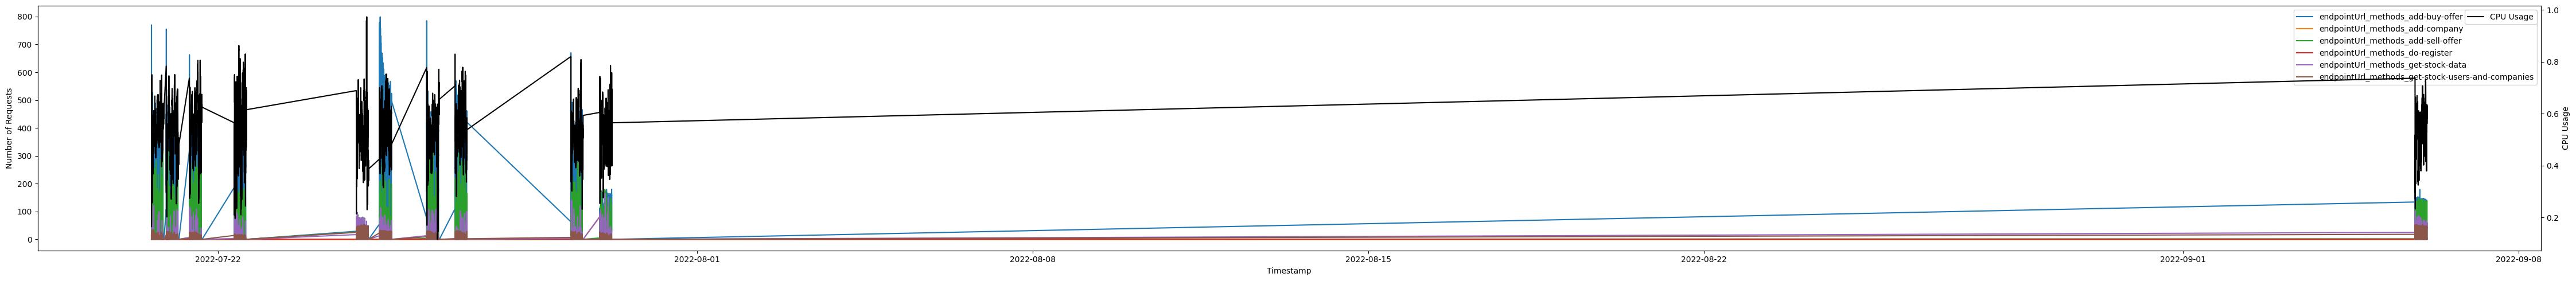

In [5]:
# Tworzenie nowej figury i osi
fig, ax1 = plt.subplots(figsize=(45, 5))

# Pobieranie kolumn zaczynających się od "endpointUrl_methods"
requests = final_df.filter(regex='^endpointUrl_methods')

# Rysowanie linii dla każdej kolumny
for column in requests.columns:
    ax1.plot(final_df.index, requests[column], label=column)

ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Number of Requests')
ax1.legend()  # dodanie legendy

# Tworzenie drugiej osi dla zużycia procesora
ax2 = ax1.twinx()
ax2.plot(final_df.index, final_df['smoothed_memoryUsage_stock'], color='black', label='CPU Usage')
ax2.set_ylabel('CPU Usage')
ax2.legend(loc='upper right')

fig.tight_layout()
plt.show()

In [6]:
testData_df = process_data(testPath)

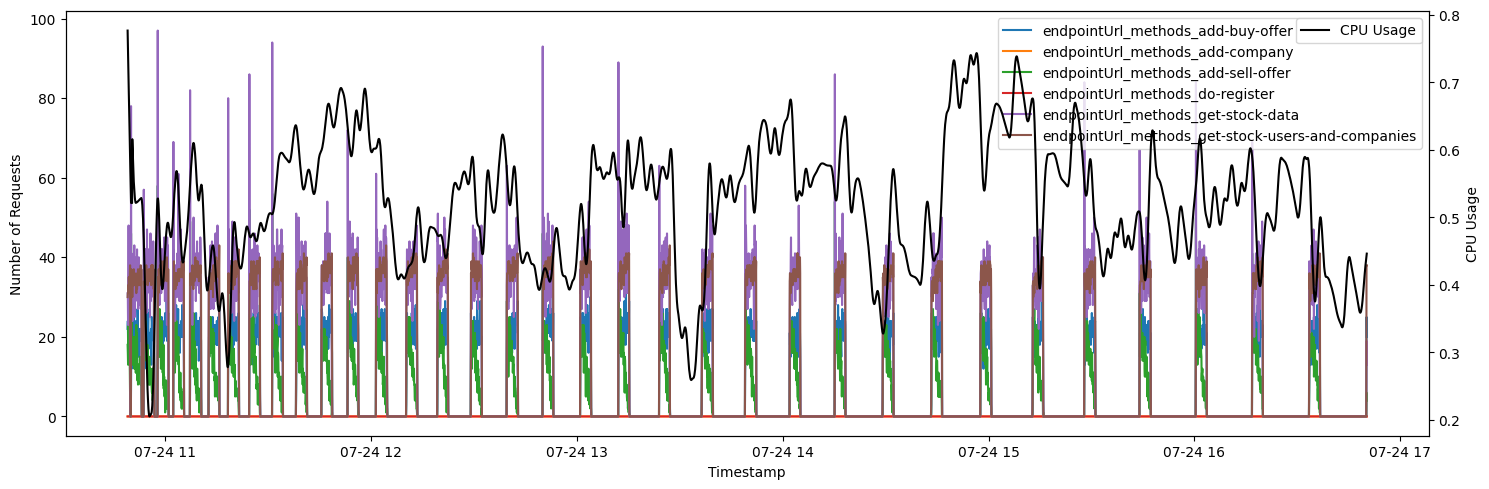

In [7]:
# Tworzenie nowej figury i osi
fig, ax1 = plt.subplots(figsize=(15, 5))

# Pobieranie kolumn zaczynających się od "endpointUrl_methods"
requests = testData_df.filter(regex='^endpointUrl_methods')

# Rysowanie linii dla każdej kolumny
for column in requests.columns:
    ax1.plot(testData_df.index, requests[column], label=column)

ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Number of Requests')
ax1.legend()  # dodanie legendy

# Tworzenie drugiej osi dla zużycia procesora
ax2 = ax1.twinx()
ax2.plot(testData_df.index, testData_df['smoothed_memoryUsage_stock'], color='black', label='CPU Usage')
ax2.set_ylabel('CPU Usage')
ax2.legend(loc='upper right')

fig.tight_layout()
plt.show()

In [8]:
cols = list(final_df.columns)
cols.remove('smoothed_memoryUsage_stock')
final_df = final_df[cols + ['smoothed_memoryUsage_stock']]

In [9]:
cols = list(testData_df.columns)
cols.remove('smoothed_memoryUsage_stock')
testData_df = testData_df[cols + ['smoothed_memoryUsage_stock']]

In [10]:
# Skalowanie danych
# scaler = MinMaxScaler()
# scaler = StandardScaler()
scaler = RobustScaler() # wiele outlierów
# scaler = Normalizer()
# scaler = QuantileTransformer()
# scaler = PowerTransformer()
scaled_df = scaler.fit_transform(final_df)

testData_df = testData_df[final_df.columns]
testData_scaled_df = scaler.transform(testData_df)

In [11]:
# Tworzenie danych do uczenia LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :-1]  # nie uwzględniaj ostatniej kolumny w X
        X.append(a)
        Y.append(dataset[i + look_back, -1])  # przewidywanie zużycia CPU
    return np.array(X), np.array(Y)

In [12]:
# train_size = int(len(scaled_df) * 0.8)
# test_size = len(scaled_df) - train_size
# train, test = scaled_df[0:train_size,:], scaled_df[train_size:len(scaled_df),:]

In [13]:
look_back = 60 # historyczne kroki czasowe do uwzględnienia
X_train, Y_train = create_dataset(scaled_df, look_back)
X_test, Y_test = create_dataset(testData_scaled_df, look_back)

In [14]:
# Tworzenie i trenowanie modelu LSTM
model = Sequential()
model.add(LSTM(20,return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(10))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [15]:
model.fit(X_train, Y_train, epochs=7, batch_size=32, verbose=2)

Epoch 1/7
1716/1716 - 41s - loss: 0.5713 - 41s/epoch - 24ms/step
Epoch 2/7
1716/1716 - 37s - loss: 0.5674 - 37s/epoch - 21ms/step
Epoch 3/7
1716/1716 - 31s - loss: 0.5643 - 31s/epoch - 18ms/step
Epoch 4/7
1716/1716 - 33s - loss: 0.5626 - 33s/epoch - 19ms/step
Epoch 5/7
1716/1716 - 43s - loss: 0.5614 - 43s/epoch - 25ms/step
Epoch 6/7
1716/1716 - 43s - loss: 0.5576 - 43s/epoch - 25ms/step
Epoch 7/7
1716/1716 - 42s - loss: 0.5545 - 42s/epoch - 24ms/step


In [16]:
# Przewidywanie na zestawie testowym
Y_pred = model.predict(X_test)

154/154 [==============================] - 2s 7ms/step


In [17]:
Y_pred_transformed = np.zeros((len(Y_pred), testData_scaled_df.shape[1]))
Y_pred_transformed[:, -1] = Y_pred[:, 0]  # wstawiamy przewidziane wartości do ostatniej kolumny
Y_pred_inv = scaler.inverse_transform(Y_pred_transformed)[:, -1]  # odwracamy skalowanie i bierzemy tylko ostatnią kolumnę

In [18]:
Y_test_transformed = np.zeros((len(Y_test), testData_scaled_df.shape[1]))
Y_test_transformed[:, -1] = Y_test  # wstawiamy prawdziwe wartości do ostatniej kolumny
Y_test_inv = scaler.inverse_transform(Y_test_transformed)[:, -1]  # odwracamy skalowanie i bierzemy tylko ostatnią kolumnę

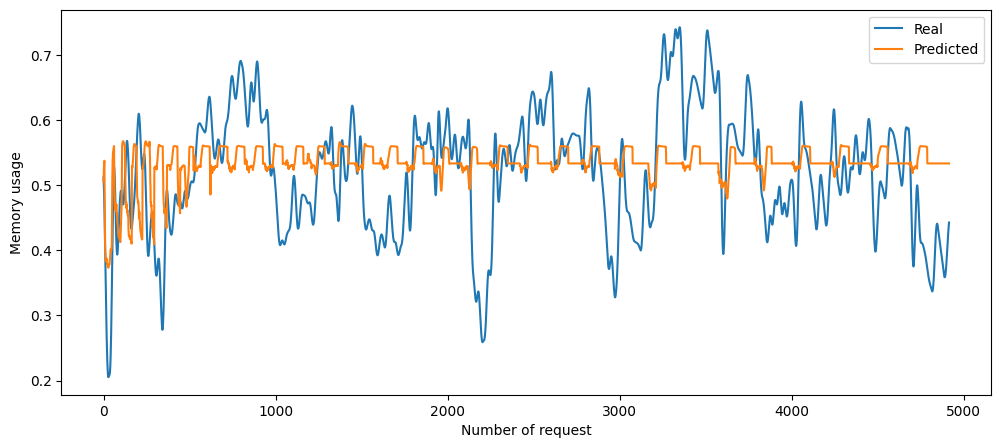

In [19]:
# Rysowanie rzeczywistych vs przewidywanych wartości
plt.figure(figsize=(12, 5))
plt.plot(Y_test_inv, label='Real')
plt.plot(Y_pred_inv, label='Predicted')
plt.ylabel('Memory usage')  
plt.xlabel('Number of request') 
plt.legend()
plt.show()